# MiniGrid settings

## Basic Jupyter Setting

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
#%load_ext autoreload
#%autoreload 2
%reload_ext autoreload
%autoreload 2

## Initial set-up

Import libraries and classes:

In [12]:
# Imports
import time
import io
import os
import glob
import torch
import base64
# import stable_baselines3

import numpy as np
import matplotlib.pyplot as plt
from random import randint 

import gym
from gym import spaces
from gym.wrappers import Monitor
import gym_minigrid
from gym_minigrid.wrappers import FlatObsWrapper, ImgObsWrapper, RGBImgPartialObsWrapper

Minigrid helper functions:

In [13]:
import base64
import glob
import io
from IPython.display import HTML
from IPython import display 
from gym.wrappers import Monitor

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")
        
def show_animation(experiment):
    giflist = glob.glob('animation/*.gif')
    if len(giflist) > 0:
        matching = [s for s in giflist if experiment in s]
        gif_path = matching[0]
        b64 = base64.b64encode(open(gif_path,'rb').read()).decode('ascii')
        display.display(HTML(f'<img src="data:image/gif;base64,{b64}" height="400" />'))
    else:
        print("Could not find animation")

## Define rendering wrappers

# Define wrapper for CNN Policy
def ImgRGBImgPartialObsWrapper(env):
    return ImgObsWrapper(RGBImgPartialObsWrapper(env))

# Monitor is a gym wrapper, which helps easy rendering of videos of the wrapped environment.
def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

def gen_wrapped_env(env_name):
    return wrap_env(FlatObsWrapper(gym.make(env_name)))

def gen_wrapped_env_cnn(env_name):
    return wrap_env(ImgObsWrapper(RGBImgPartialObsWrapper(gym.make(env_name))))

Render an environment image:

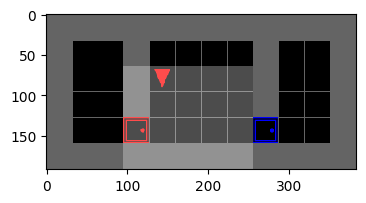

In [22]:
from random import randint
#env_id = 'MiniGrid-Empty-5x5-v0'
#env_id = 'MiniGrid-Empty-Random-6x6-v0'
#env_id = 'MiniGrid-Empty-8x8-v0'
#env_id = 'MiniGrid-Empty-16x16-v0'
#env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id = 'BreakoutNoFrameskip-v4'
#env_id = 'MiniGrid-DistShift1-v0'
#env_id ='MiniGrid-UnlockPickup-v0'
env_id = 'MiniGrid-RedBlueDoors-6x6-v0'
#env_id = 'MiniGrid-LavaGapS6-v0'
#env_id = 'MiniGrid-WallGapS6-v0'
#env_id = 'MiniGrid-SimpleCrossingS9N2-v0'
#env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id = 'MiniGrid-DoorKeyLava-6x6-v0'

eval_env = gym.make(env_id)
eval_env.seed(10000+randint(0, 10))
eval_env.reset()
#random_action = eval_env.action_space.sample()
#new_obs, reward, done, info = eval_env.step(random_action)

before_img = eval_env.render('rgb_array')

plt.figure(figsize = (4.,4.))
plt.imshow(before_img);

# Policy Consolidation learning

## Define the environments

### Import libraries

In [14]:
import time
import io
import os
import glob
import base64
import datetime
import torch
import torch_ac
import tensorboardX
import sys
import utils
from model import ACModel
from torch_ac.utils import DictList, ParallelEnv
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

import gym
from gym import spaces
from gym.wrappers import Monitor
import gym_minigrid
from gym_minigrid.wrappers import FlatObsWrapper, ImgObsWrapper, RGBImgPartialObsWrapper

### Helper functions

In [15]:
def make_envs(env_id, procs, seed=None):
    envs = []
    for i in range(procs):
        if seed:
            e = utils.make_env(env_id, seed + 10000 * i)
        else:
            e = utils.make_env(env_id)
        envs.append(e)
    env = ParallelEnv(envs)
    return env

# functions to calculate decays
def constfn(val):
    def f(_):
        return val
    return f

def constfn_arr(val,length):
    return [val for i in range(length)]

def constfn_arr2(val,length):
    def f(_):
        return [val for i in range(length)]
    return f

def decayfn_arr_2(start, decay, length):
    def f(start):
        return [start*decay**i for i in range(length)]
    return f

def decayfn_arr(start, decay, length):
    return [start*decay**i for i in range(length)]


### Render Parallel environment snapshot

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

procs = 16
max_tasks = 20
seed_list = range(procs * max_tasks, (procs + 1) * max_tasks)

#env_id = 'MiniGrid-Empty-Random-6x6-v0'
#env_id = 'MiniGrid-Empty-5x5-v0'
#env_id = 'MiniGrid-DoorKey-5x5-v0'
#env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id = 'MiniGrid-LavaGapS6-v0'
#env_id = 'MiniGrid-SimpleCrossingS9N1-v0'
#env_id = 'MiniGrid-SimpleCrossingS9N2-v0'
#env_id = 'MiniGrid-SimpleCrossingS9N3-v0'
#env_id = 'MiniGrid-SimpleCrossingS11N5-v0'
#env_id = 'MiniGrid-WallGapS6-v0'
#env_id = 'MiniGrid-LavaCrossingS9N2-v0'
env_id = 'MiniGrid-SimpleCrossingS9N2-v0'

seed = 1
env = make_envs(env_id, procs, seed)
obs = env.reset()

im_list = []
for e in env.envs:
    #print(type(e.render('rgb_array')))
    #e.reset()
    im_list.append(e.render('rgb_array'))

fig = plt.figure(figsize=(8., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, im_list):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

#plt.show()


## Configuration

### Load parameters

In [16]:
#env_id = 'MiniGrid-Empty-8x8-v0'
#env_id = 'MiniGrid-LavaGapS5-v0'
#env_id = 'MiniGrid-DoorKey-5x5-v0'
#env_id = 'MiniGrid-DoorKey-5x5-v0'
env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id = 'MiniGrid-WallGapS6-v0'
#env_id = 'MiniGrid-Empty-Random-6x6-v0'
#env_id = 'MiniGrid-Empty-5x5-v0'
#model = 'MiniGrid-WallGapS6-v0_PPOPC_RMSProp_frames_1M_proc_16_cascade_2_nodecay_next_MiniGrid-DoorKey-6x6-v0_mid'
model = 'test_cascade_8_rmsprop_steps_1e6_seed_1_doorkey_wallgap_lavagap'

processes = 16
frames = 1e6

## Hyper-parameters
args = {
# General parameters
'algo':'ppopc',
'env':env_id,
'model':model,
'early_stop':False,
'seed':1,
'log_interval':1,
'save_interval':10,
'procs':processes,
'frames':frames, # default 1e7
# Parameters for main algorithm
'epochs':4,
'batch_size':256,
'frames_per_proc':2048, # 128 for PPO and 5 per A2C
'discount':0.99,
#'lr':2.5e-4,#0.0001, # for Adam
'lr':0.0007, # for RMSProp
#'gae_lambda':0.95, # 1 means no gae, for Adam
'gae_lambda':0.99, # 1 means no gae, for RMSProp
'entropy_coef': 0.01,
'value_loss_coef':0.5,
'max_grad_norm':0.5,
'optim_eps':1e-8,
'optim_alpha':0.99,
'clip_eps':0.2,
'recurrence':1, # if > 1, a LSTM is added
'text':False, # add a GRU for text input
# Model Parameters
'cascade_depth':8,
'flow_factor':1.0,
'mesh_factor':4.0,
'lr_decay':True,
'imp_sampling':'clipped',
'imp_clips': [-5,5],
'dynamic_neglogpacs':False,
'optimizer_type':'rmsprop',
#'optimizer_type':'adam',
'scheduler_flag':False,
'var_init':'equal',
'reshape_reward':False
}

#args = utils.dotdict(args)
args = DictList(args)

args.mem = args.recurrence > 1

# Create decay learning rates and clip ranges
if isinstance(args.lr, float):
    if args.lr_decay:
        args.lrs = decayfn_arr(args.lr,1.0/args.mesh_factor, args.cascade_depth) # learning rates exponentially smaller for deeper policies in cascade
        args.lrs_fn = decayfn_arr_2(args.lr,1.0/args.mesh_factor, args.cascade_depth)
    else:
        args.lrs = constfn_arr(args.lr,args.cascade_depth)
        args.lrs_fn = None
else: assert callable(args.lr)
if isinstance(args.clip_eps, float):
    if args.lr_decay:
        args.clipranges = decayfn_arr(args.clip_eps,1.0/args.mesh_factor, args.cascade_depth)
    else:
        args.clipranges = constfn_arr(args.clip_eps, args.cascade_depth)

else: assert callable(args.clip_eps)

### Initial settings

In [17]:
# Set run dir

date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M-%S")
default_model_name = f"{args.env}_{args.algo}_seed{args.seed}_{date}"

model_name = args.model or default_model_name
model_dir = utils.get_model_dir(model_name)

# Load loggers and Tensorboard writer

txt_logger = utils.get_txt_logger(model_dir)
csv_file, csv_logger = utils.get_csv_logger(model_dir)
tb_writer = tensorboardX.SummaryWriter(model_dir)

# Log command and all script arguments

#txt_logger.info("{}\n".format(" ".join(sys.argv)))
txt_logger.info("{}\n".format(args))

# Set seed for all randomness sources

utils.seed(args.seed)

# Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
txt_logger.info(f"Device: {device}\n")

{'algo': 'ppopc', 'env': 'MiniGrid-DoorKey-6x6-v0', 'model': 'test_cascade_8_rmsprop_steps_1e6_seed_1_doorkey_wallgap_lavagap', 'early_stop': False, 'seed': 1, 'log_interval': 1, 'save_interval': 10, 'procs': 16, 'frames': 1000000.0, 'epochs': 4, 'batch_size': 256, 'frames_per_proc': 2048, 'discount': 0.99, 'lr': 0.0007, 'gae_lambda': 0.99, 'entropy_coef': 0.01, 'value_loss_coef': 0.5, 'max_grad_norm': 0.5, 'optim_eps': 1e-08, 'optim_alpha': 0.99, 'clip_eps': 0.2, 'recurrence': 1, 'text': False, 'cascade_depth': 8, 'flow_factor': 1.0, 'mesh_factor': 4.0, 'lr_decay': True, 'imp_sampling': 'clipped', 'imp_clips': [-5, 5], 'dynamic_neglogpacs': False, 'optimizer_type': 'rmsprop', 'scheduler_flag': False, 'var_init': 'equal', 'reshape_reward': False, 'mem': False, 'lrs': [0.0007, 0.000175, 4.375e-05, 1.09375e-05, 2.734375e-06, 6.8359375e-07, 1.708984375e-07, 4.2724609375e-08], 'lrs_fn': <function decayfn_arr_2.<locals>.f at 0x14b547200>, 'clipranges': [0.2, 0.05, 0.0125, 0.003125, 0.000781

### Load environments, model, algo and prepare training settings

In [18]:
# Load environments

envs = []
for i in range(args.procs):
    envs.append(utils.make_env(args.env, args.seed + 10000 * i))
txt_logger.info("Environments loaded\n")

# Load training status

try:
    status = utils.get_status(model_dir)
except OSError:
    status = {"num_frames": 0, "update": 0}
txt_logger.info("Training status loaded\n")

# Load observations preprocessor

obs_space, preprocess_obss = utils.get_obss_preprocessor(envs[0].observation_space)
if "vocab" in status:
    preprocess_obss.vocab.load_vocab(status["vocab"])
txt_logger.info("Observations preprocessor loaded")

# Reshape reward function
if args.reshape_reward:
    def reshape_reward(obs, action, reward, done):
        if not done:
            reward = -1
        else:
            reward = 1
        return reward
else:
    reshape_reward = None

# Load model

acmodel = ACModel(obs_space=obs_space, action_space=envs[0].action_space, use_memory=args.mem, use_text=args.text)
if "model_state" in status:
    acmodel.load_state_dict(status["model_state"])
acmodel.to(device)
txt_logger.info("Model loaded\n")
txt_logger.info("{}\n".format(acmodel))

# Create hidden policies

acmodels = [acmodel]

for k in range(1, args.cascade_depth):
    hidden_acmodel = ACModel(obs_space=obs_space, action_space=envs[0].action_space, use_memory=args.mem, use_text=args.text)
    hidden_acmodel.to(device)
    # Initialise all hidden policy networks to same as visible policy
    if args.var_init == "equal":
        hidden_acmodel.load_state_dict(acmodel.state_dict())
    elif args.var_init == "saved":
        hidden_acmodel.load_state_dict(status["hidden_model_states"][k-1])
    acmodels.append(hidden_acmodel)
txt_logger.info("Hidden models loaded\n")

Environments loaded

Training status loaded

Observations preprocessor loaded
Model loaded

ACModel(
  (image_conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
    (4): ReLU()
    (5): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
    (6): ReLU()
  )
  (actor): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=7, bias=True)
  )
  (critic): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

Hidden models loaded



In [19]:
# Load algo

if args.algo == "a2c":
    algo = torch_ac.A2CAlgo(envs, acmodel, device, args.frames_per_proc, args.discount, args.lr, args.gae_lambda,
                            args.entropy_coef, args.value_loss_coef, args.max_grad_norm, args.recurrence,
                            args.optim_alpha, args.optim_eps, preprocess_obss)
elif args.algo == "ppo":
    algo = torch_ac.PPOAlgo(envs, acmodel, device, args.frames_per_proc, args.discount, args.lr, args.gae_lambda,
                            args.entropy_coef, args.value_loss_coef, args.max_grad_norm, args.recurrence,
                            args.optim_eps, args.clip_eps, args.epochs, args.batch_size, preprocess_obss)
elif args.algo == "ppopc":
    algo = torch_ac.PPOPCAlgo(envs, acmodels, device, args.frames_per_proc, args.discount, args.lr, args.gae_lambda,
                            args.entropy_coef, args.value_loss_coef, args.max_grad_norm, args.recurrence,
                            args.optim_eps, args.clip_eps, args.epochs, args.batch_size, preprocess_obss, args.cascade_depth, args.flow_factor, args.mesh_factor, args.imp_sampling, args.imp_clips, args.dynamic_neglogpacs, args.lrs, args.lrs_fn, args.clipranges, args.optimizer_type, args.scheduler_flag, reshape_reward)                              
else:
    raise ValueError("Incorrect algorithm name: {}".format(args.algo))

algo.renew_optimizer()
# if "optimizer_state" in status:
#     algo.optimizer.load_state_dict(status["optimizer_state"])
# txt_logger.info("Optimizer loaded\n")

## Training

In [ ]:
# Train model

num_frames = status["num_frames"]
update = status["update"]
start_time = time.time()
#nupdates = args.frames // (args.procs * args.frames_per_proc)

# Moving average parameters
threshold = 0.90
window = 20
rreturn_total = 0
i = 0

while num_frames < args.frames:

    update_start_time = time.time()

    # Evaluate decay lr and cliprange    
    # frac = 1.0 - (update - 1.0) / nupdates
    # algo.lrs = lrs(frac)
    # algo.clipranges = clip_epss(frac)
    # algo.kl_betas = None # Clipped-PPO, not full KL

    # Collect experiences for cascade policies
    exps, logs1 = algo.collect_experiences_cascade()

    # Update model parameters
    logs2 = algo.update_parameters_cascade(exps)
    logs = {**logs1, **logs2}
    update_end_time = time.time()

    num_frames += logs["num_frames"]
    update += 1

    # Print logs

    if update % args.log_interval == 0:
        fps = logs["num_frames"]/(update_end_time - update_start_time)
        duration = int(time.time() - start_time)
        return_per_episode = utils.synthesize(logs["return_per_episode"])
        rreturn_per_episode = utils.synthesize(logs["reshaped_return_per_episode"])
        num_frames_per_episode = utils.synthesize(logs["num_frames_per_episode"])
        # Moving average to break loop if mean reward threshold reached
        #rreturn_total +=rreturn_per_episode['mean']
        if args.early_stop:
            rreturn_total +=return_per_episode['mean']
            i+=1
            if i >= window:
                rreturn_mavg = rreturn_total / i
                if rreturn_mavg >= threshold:
                    break_flag = True 
                    break
                else:
                    i = 0
                    rreturn_total = 0

        header = ["update", "frames", "FPS", "duration"]
        data = [update, num_frames, fps, duration]
        # header += ["rreturn_" + key for key in rreturn_per_episode.keys()]
        # data += rreturn_per_episode.values()
        header += ["rreturn_" + key for key in return_per_episode.keys()]
        data += return_per_episode.values()        
        header += ["num_frames_" + key for key in num_frames_per_episode.keys()]
        data += num_frames_per_episode.values()
        header += ["entropy", "value", "policy_loss", "value_loss", "grad_norm"]
        data += [logs["entropy"], logs["value"], logs["policy_loss"], logs["value_loss"], logs["grad_norm"]]

        txt_logger.info(
            "U {} | F {:06} | FPS {:04.0f} | D {} | rR:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {} | H {:.3f} | V {:.3f} | pL {:.3f} | vL {:.3f} | ∇ {:.3f}"
            .format(*data))

        header += ["return_" + key for key in return_per_episode.keys()]
        data += return_per_episode.values()

        if status["num_frames"] == 0:
            csv_logger.writerow(header)
        csv_logger.writerow(data)
        csv_file.flush()

        for field, value in zip(header, data):
            tb_writer.add_scalar(field, value, num_frames)

    # Save status

    if args.save_interval > 0 and update % args.save_interval == 0:
        status = {"num_frames": num_frames, "update": update,
                  "model_state": acmodels[0].state_dict(), "optimizer_state": algo.optimizer.state_dict()}
        if hasattr(preprocess_obss, "vocab"):
            status["vocab"] = preprocess_obss.vocab.vocab
        if args.cascade_depth > 1:
            status["hidden_model_states"] = [acmodels[k].state_dict() for k in range(1, args.cascade_depth)]
        utils.save_status(status, model_dir)
        txt_logger.info("Status saved")

print("Number of frames: ", num_frames)

## Evaluation

### Load parameters

In [ ]:
from torch_ac.utils.penv import ParallelEnv

#env_id = 'MiniGrid-Empty-Random-6x6-v0'
env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id = 'MiniGrid-Empty-8x8-v0'
#env_id = 'MiniGrid-WallGapS6-v0'

## Hyper-parameters
args.env = env_id
args.episodes = 100
args.seed = 2
# Deterministic actions for evaluation, no exploit, no need of randomness for exploration
args.argmax = True 
args.worst_episodes_to_show = None
print(args)

# Set seed for all randomness sources
utils.seed(args.seed)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}\n")

### Set environments, agent and logs, Run agent and print results

In [ ]:
num_frames_list = []
fps_list = []
duration_list = []
return_per_episode_list = []
num_frames_per_episode_list = []
seed_list = [10, 20, 30]

print("Env:", args.env, "\n")

for n, seed in enumerate(seed_list):

    # Load environments

    envs = []
    for i in range(args.procs):
        env = utils.make_env(args.env, seed + 10000 * i)
        envs.append(env)
    env = ParallelEnv(envs)
    print("Environments loaded")

    # Load agent

    model_dir = utils.get_model_dir(args.model)
    agent = utils.Agent(obs_space=env.observation_space, action_space=env.action_space, model_dir=model_dir, device=device, argmax=args.argmax)
    print("Agent loaded")

    # Initialize logs

    logs = {"num_frames_per_episode": [], "return_per_episode": []}

    # Run agent

    start_time = time.time()

    obss = env.reset()

    log_done_counter = 0
    log_episode_return = torch.zeros(args.procs, device=device)
    log_episode_num_frames = torch.zeros(args.procs, device=device)

    while log_done_counter < args.episodes:
        actions = agent.get_actions(obss)
        obss, rewards, dones, _ = env.step(actions)
        agent.analyze_feedbacks(rewards, dones)

        log_episode_return += torch.tensor(rewards, device=device, dtype=torch.float)
        log_episode_num_frames += torch.ones(args.procs, device=device)

        for i, done in enumerate(dones):
            if done:
                log_done_counter += 1
                logs["return_per_episode"].append(log_episode_return[i].item())
                logs["num_frames_per_episode"].append(log_episode_num_frames[i].item())

        mask = 1 - torch.tensor(dones, device=device, dtype=torch.float)
        log_episode_return *= mask
        log_episode_num_frames *= mask

    end_time = time.time()
    print("Agent run_{} completed\n" .format(n+1))

    num_frames = sum(logs["num_frames_per_episode"])
    fps = num_frames/(end_time - start_time)
    duration = int(end_time - start_time)
    return_per_episode = utils.synthesize(logs["return_per_episode"])
    num_frames_per_episode = utils.synthesize(logs["num_frames_per_episode"])

    # Acumulate logs per agent

    num_frames_list.append(num_frames)
    fps_list.append(fps)
    duration_list.append(duration)
    return_per_episode_list.append(np.fromiter(return_per_episode.values(), float))
    num_frames_per_episode_list.append(np.fromiter(num_frames_per_episode.values(), float))

# Convert lists to numpy arrays
num_frames_tot = np.array(num_frames_list, ndmin=2)
fps_tot = np.array(fps_list, ndmin=2)
duration_tot = np.array(duration_list, ndmin=2)
return_per_episode_tot = np.array(return_per_episode_list, ndmin=2)
num_frames_per_episode_tot = np.array(num_frames_per_episode_list, ndmin=2)

# Print logs

print("F {} | FPS {:.0f} | D {} | R:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {}"
      .format(np.median(num_frames_tot, axis=0)[0], np.median(fps_tot, axis=0)[0], np.median(duration_tot, axis=0)[0], *np.median(return_per_episode_tot, axis=0), *np.median(num_frames_per_episode_tot, axis=0)))

#return_per_episode_tot = np.array(return_per_episode_tot, ndim=2)

# Print worst episodes
if args.worst_episodes_to_show:
    n = args.worst_episodes_to_show
    if n > 0:
        print("\n{} worst episodes:".format(n))

        indexes = sorted(range(len(logs["return_per_episode"])), key=lambda k: logs["return_per_episode"][k])
        for i in indexes[:n]:
            print("- episode {}: R={}, F={}".format(i, logs["return_per_episode"][i], logs["num_frames_per_episode"][i]))

## Visualization

### Load parameters

In [ ]:
import array2gif
from pathlib import Path
import numpy

## Hyper-parameters
args = {
# General parameters
'env':args.env,
'model':args.model,
'seed':15,
'shift':0,
'argmax':True,
'pause':0.1,
'gif':args.model,
'episodes':5
}

args = DictList(args)
print(args)

### Set environment, agent and logs

In [ ]:
# Set seed for all randomness sources

utils.seed(args.seed)

# Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}\n")

# Load environment

env = utils.make_env(args.env, args.seed)
for _ in range(args.shift):
    env.reset()
print("Environment loaded\n")

# Load agent

model_dir = utils.get_model_dir(args.model)
agent = utils.Agent(env.observation_space, env.action_space, model_dir, device, args.argmax)

print("Agent loaded\n")

### Make animation

In [ ]:
%%capture
# Run the agent

if args.gif:
   from array2gif import write_gif
   frames = []

# Create a window to view the environment
env.render('human')

for episode in range(args.episodes):
    obs = env.reset()
    done2 = False
    while True:
        env.render('human')
        if args.gif:
            frames.append(numpy.moveaxis(env.render("rgb_array"), 2, 0))
            

        action = agent.get_action(obs)
        obs, reward, done, _ = env.step(action)
        agent.analyze_feedback(reward, done)
        
        if done or env.window.closed:
            if episode == 4:
                done2 = True
            break
    if done2 == True:
        env.close()
        break
    #if env.window.closed:
    #    break
print('doneeee')
if args.gif:
    print("Saving gif... ", end="")
    utils.create_folders_if_necessary("./animation")
    #Path("./animation").mkdir(parents=True, exist_ok=True)
    write_gif(numpy.array(frames), "./animation/"+args.gif+".gif")
    print("Done.")

In [ ]:
show_animation(args.model)

### Make video

In [ ]:
test_env = wrap_env(env)
observation = test_env.reset()

done = False
episode_reward = 0
episode_length = 0

while not done:
    action = agent.get_action(observation)
    observation, reward, done, info = test_env.step(action)
    episode_reward += reward
    episode_length += 1

print('Total reward:', episode_reward)
print('Total length:', episode_length)

test_env.close()
show_video()

# Continue learning on 2nd environment

## Configuration

### Set general parameters

In [ ]:
#env_id = 'MiniGrid-Empty-8x8-v0'
#env_id = 'MiniGrid-LavaGapS5-v0'
#env_id = 'MiniGrid-DoorKey-5x5-v0'
#env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id = 'MiniGrid-Empty-Random-6x6-v0'
#env_id = 'MiniGrid-Empty-5x5-v0'
env_id = 'MiniGrid-WallGapS6-v0'

#model = 'MiniGrid-DoorKey-6x6-v0_meta_RIM_5_3_frames_500k_tasks_2_recur_64_16_proc_16_RMSProp_lr_7e4_gae_099_newloop_changeseed'

add_frames = 1e6
frames = frames + add_frames

## Hyper-parameters
args = {
# General parameters
'algo':'ppopc',
'env':env_id,
'model':model,
'early_stop':False,
'seed':1,
'log_interval':1,
'save_interval':10,
'procs':processes,
'frames':frames, # default 1e7
# Parameters for main algorithm
'epochs':4,
'batch_size':256,
'frames_per_proc':2048, # 128 for PPO and 5 per A2C
'discount':0.99,
#'lr':2.5e-4,#0.0001, # for Adam
'lr':0.0007, # for RMSProp
#'gae_lambda':0.95, # 1 means no gae, for Adam
'gae_lambda':0.99, # 1 means no gae, for RMSProp
'entropy_coef': 0.01,
'value_loss_coef':0.5,
'max_grad_norm':0.5,
'optim_eps':1e-8,
'optim_alpha':0.99,
'clip_eps':0.2,
'recurrence':1, # if > 1, a LSTM is added
'text':False, # add a GRU for text input
# Model Parameters
'cascade_depth':8,
'flow_factor':1.0,
'mesh_factor':4.0,
'lr_decay':True,
'imp_sampling':'clipped',
'imp_clips': [-5,5],
'dynamic_neglogpacs':False,
'optimizer_type':'rmsprop',
#'optimizer_type':'adam',
'scheduler_flag':False,
'var_init':'saved', #'equal',
'reshape_reward':False
}

#args = utils.dotdict(args)
args = DictList(args)

args.mem = args.recurrence > 1

# Create decay learning rates and clip ranges
if isinstance(args.lr, float):
    if args.lr_decay:
        args.lrs = decayfn_arr(args.lr,1.0/args.mesh_factor, args.cascade_depth) # learning rates exponentially smaller for deeper policies in cascade
        args.lrs_fn = decayfn_arr_2(args.lr,1.0/args.mesh_factor, args.cascade_depth)
    else:
        args.lrs = constfn_arr(args.lr,args.cascade_depth)
        args.lrs_fn = None
else: assert callable(args.lr)
if isinstance(args.clip_eps, float):
    if args.lr_decay:
        args.clipranges = decayfn_arr(args.clip_eps,1.0/args.mesh_factor, args.cascade_depth)
    else:
        args.clipranges = constfn_arr(args.clip_eps, args.cascade_depth)

else: assert callable(args.clip_eps)

### Load previous loggers and settings

In [ ]:
date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M-%S")
default_model_name = f"{args.env}_{args.algo}_seed{args.seed}_{date}"

model_name = args.model or default_model_name
model_dir = utils.get_model_dir(model_name)

# Load loggers and Tensorboard writer

txt_logger = utils.get_txt_logger(model_dir)
csv_file, csv_logger = utils.get_csv_logger(model_dir)
tb_writer = tensorboardX.SummaryWriter(model_dir)

# Log command and all script arguments

#txt_logger.info("{}\n".format(" ".join(sys.argv)))
txt_logger.info("{}\n".format(args))

# Set seed for all randomness sources

utils.seed(args.seed)

# Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
txt_logger.info(f"Device: {device}\n")

### Load existing environments, model and training status

In [ ]:
# Load environments

envs = []
for i in range(args.procs):
    envs.append(utils.make_env(args.env, args.seed + 10000 * i))
txt_logger.info("Environments loaded\n")

# Load training status

try:
    status = utils.get_status(model_dir)
except OSError:
    status = {"num_frames": 0, "update": 0}
txt_logger.info("Training status loaded\n")

# Load observations preprocessor

obs_space, preprocess_obss = utils.get_obss_preprocessor(envs[0].observation_space)
if "vocab" in status:
    preprocess_obss.vocab.load_vocab(status["vocab"])
txt_logger.info("Observations preprocessor loaded")

# Reshape reward function
if args.reshape_reward:
    def reshape_reward(obs, action, reward, done):
        if not done:
            reward = -1
        else:
            reward = 1
        return reward
else:
    reshape_reward = None

# Load model

acmodel = ACModel(obs_space=obs_space, action_space=envs[0].action_space, use_memory=args.mem, use_text=args.text)
if "model_state" in status:
    acmodel.load_state_dict(status["model_state"])
acmodel.to(device)
txt_logger.info("Model loaded\n")
txt_logger.info("{}\n".format(acmodel))

# Create hidden policies

acmodels = [acmodel]

for k in range(1, args.cascade_depth):
    hidden_acmodel = ACModel(obs_space=obs_space, action_space=envs[0].action_space, use_memory=args.mem, use_text=args.text)
    hidden_acmodel.to(device)
    # Initialise all hidden policy networks to same as visible policy
    if args.var_init == "equal":
        print("Hidden policies initialized as visible policy")
        hidden_acmodel.load_state_dict(acmodel.state_dict())
    elif args.var_init == "saved":
        print("Hidden policies initialized with previous saved states")
        hidden_acmodel.load_state_dict(status["hidden_model_states"][k-1])
    acmodels.append(hidden_acmodel)
txt_logger.info("Hidden models loaded\n")

In [ ]:
# Load algo

if args.algo == "a2c":
    algo = torch_ac.A2CAlgo(envs, acmodel, device, args.frames_per_proc, args.discount, args.lr, args.gae_lambda,
                            args.entropy_coef, args.value_loss_coef, args.max_grad_norm, args.recurrence,
                            args.optim_alpha, args.optim_eps, preprocess_obss)
elif args.algo == "ppo":
    algo = torch_ac.PPOAlgo(envs, acmodel, device, args.frames_per_proc, args.discount, args.lr, args.gae_lambda,
                            args.entropy_coef, args.value_loss_coef, args.max_grad_norm, args.recurrence,
                            args.optim_eps, args.clip_eps, args.epochs, args.batch_size, preprocess_obss)
elif args.algo == "ppopc":
    algo = torch_ac.PPOPCAlgo(envs, acmodels, device, args.frames_per_proc, args.discount, args.lr, args.gae_lambda,
                            args.entropy_coef, args.value_loss_coef, args.max_grad_norm, args.recurrence,
                            args.optim_eps, args.clip_eps, args.epochs, args.batch_size, preprocess_obss, args.cascade_depth, args.flow_factor, args.mesh_factor, args.imp_sampling, args.imp_clips, args.dynamic_neglogpacs, args.lrs, args.lrs_fn, args.clipranges, args.optimizer_type, args.scheduler_flag, reshape_reward)                              
else:
    raise ValueError("Incorrect algorithm name: {}".format(args.algo))

algo.renew_optimizer()
# if "optimizer_state" in status:
#     algo.optimizer.load_state_dict(status["optimizer_state"])
# txt_logger.info("Optimizer loaded\n")

## Continue training

In [ ]:
# Train model

num_frames = status["num_frames"]
update = status["update"]
start_time = time.time()
#nupdates = args.frames // (args.procs * args.frames_per_proc)

# Moving average parameters
threshold = 0.90
window = 10
rreturn_total = 0
i = 0

while num_frames < args.frames:

    update_start_time = time.time()

    # Collect experiences for cascade policies
    exps, logs1 = algo.collect_experiences_cascade()

    # Update model parameters
    logs2 = algo.update_parameters_cascade(exps)
    logs = {**logs1, **logs2}
    update_end_time = time.time()

    num_frames += logs["num_frames"]
    update += 1

    # Print logs

    if update % args.log_interval == 0:
        fps = logs["num_frames"]/(update_end_time - update_start_time)
        duration = int(time.time() - start_time)
        return_per_episode = utils.synthesize(logs["return_per_episode"])
        rreturn_per_episode = utils.synthesize(logs["reshaped_return_per_episode"])
        num_frames_per_episode = utils.synthesize(logs["num_frames_per_episode"])
        # Moving average to break loop if mean reward threshold reached
        #rreturn_total +=rreturn_per_episode['mean']
        if args.early_stop:
            rreturn_total +=return_per_episode['mean']
            i+=1
            if i >= window:
                rreturn_mavg = rreturn_total / i
                if rreturn_mavg >= threshold:
                    break_flag = True 
                    break
                else:
                    i = 0
                    rreturn_total = 0

        header = ["update", "frames", "FPS", "duration"]
        data = [update, num_frames, fps, duration]
        # header += ["rreturn_" + key for key in rreturn_per_episode.keys()]
        # data += rreturn_per_episode.values()
        header += ["rreturn_" + key for key in return_per_episode.keys()]
        data += return_per_episode.values()
        header += ["num_frames_" + key for key in num_frames_per_episode.keys()]
        data += num_frames_per_episode.values()
        header += ["entropy", "value", "policy_loss", "value_loss", "grad_norm"]
        data += [logs["entropy"], logs["value"], logs["policy_loss"], logs["value_loss"], logs["grad_norm"]]

        txt_logger.info(
            "U {} | F {:06} | FPS {:04.0f} | D {} | rR:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {} | H {:.3f} | V {:.3f} | pL {:.3f} | vL {:.3f} | ∇ {:.3f}"
            .format(*data))

        header += ["return_" + key for key in return_per_episode.keys()]
        data += return_per_episode.values()

        if status["num_frames"] == 0:
            csv_logger.writerow(header)
        csv_logger.writerow(data)
        csv_file.flush()

        for field, value in zip(header, data):
            tb_writer.add_scalar(field, value, num_frames)

    # Save status

    if args.save_interval > 0 and update % args.save_interval == 0:
        status = {"num_frames": num_frames, "update": update,
                  "model_state": acmodels[0].state_dict(), "optimizer_state": algo.optimizer.state_dict()}
        if hasattr(preprocess_obss, "vocab"):
            status["vocab"] = preprocess_obss.vocab.vocab
        if args.cascade_depth > 1:
            status["hidden_model_states"] = [acmodels[k].state_dict() for k in range(1, args.cascade_depth)]
        utils.save_status(status, model_dir)
        txt_logger.info("Status saved")

print("Number of frames: ", num_frames)

## Evaluate 2nd environment

### Load parameters

In [ ]:
#env_id = 'MiniGrid-Empty-Random-6x6-v0'
#env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id = 'MiniGrid-Empty-8x8-v0'
#env_id = 'MiniGrid-LavaGapS5-v0'
env_id = 'MiniGrid-WallGapS6-v0'

## Hyper-parameters
args.env = env_id
args.episodes = 100
args.seed = 2
args.argmax = True # Deterministic for evaluation
args.worst_episodes_to_show = None
print(args)

# Set seed for all randomness sources
utils.seed(args.seed)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}\n")

### Set environments, agent and logs, run agent and print results

In [ ]:
num_frames_list = []
fps_list = []
duration_list = []
return_per_episode_list = []
num_frames_per_episode_list = []
seed_list = [10, 20, 30]

print("Env:", args.env, "\n")

for n, seed in enumerate(seed_list):

    # Load environments

    envs = []
    for i in range(args.procs):
        env = utils.make_env(args.env, seed + 10000 * i)
        envs.append(env)
    env = ParallelEnv(envs)
    print("Environments loaded")

    # Load agent

    model_dir = utils.get_model_dir(args.model)
    agent = utils.Agent(obs_space=env.observation_space, action_space=env.action_space, model_dir=model_dir, device=device, argmax=args.argmax)
    print("Agent loaded")

    # Initialize logs

    logs = {"num_frames_per_episode": [], "return_per_episode": []}

    # Run agent

    start_time = time.time()

    obss = env.reset()

    log_done_counter = 0
    log_episode_return = torch.zeros(args.procs, device=device)
    log_episode_num_frames = torch.zeros(args.procs, device=device)

    while log_done_counter < args.episodes:
        actions = agent.get_actions(obss)
        obss, rewards, dones, _ = env.step(actions)
        agent.analyze_feedbacks(rewards, dones)

        log_episode_return += torch.tensor(rewards, device=device, dtype=torch.float)
        log_episode_num_frames += torch.ones(args.procs, device=device)

        for i, done in enumerate(dones):
            if done:
                log_done_counter += 1
                logs["return_per_episode"].append(log_episode_return[i].item())
                logs["num_frames_per_episode"].append(log_episode_num_frames[i].item())

        mask = 1 - torch.tensor(dones, device=device, dtype=torch.float)
        log_episode_return *= mask
        log_episode_num_frames *= mask

    end_time = time.time()
    print("Agent run_{} completed\n" .format(n+1))

    num_frames = sum(logs["num_frames_per_episode"])
    fps = num_frames/(end_time - start_time)
    duration = int(end_time - start_time)
    return_per_episode = utils.synthesize(logs["return_per_episode"])
    num_frames_per_episode = utils.synthesize(logs["num_frames_per_episode"])

    # Acumulate logs per agent

    num_frames_list.append(num_frames)
    fps_list.append(fps)
    duration_list.append(duration)
    return_per_episode_list.append(np.fromiter(return_per_episode.values(), float))
    num_frames_per_episode_list.append(np.fromiter(num_frames_per_episode.values(), float))

# Convert lists to numpy arrays
num_frames_tot = np.array(num_frames_list, ndmin=2)
fps_tot = np.array(fps_list, ndmin=2)
duration_tot = np.array(duration_list, ndmin=2)
return_per_episode_tot = np.array(return_per_episode_list, ndmin=2)
num_frames_per_episode_tot = np.array(num_frames_per_episode_list, ndmin=2)

# Print logs

print("F {} | FPS {:.0f} | D {} | R:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {}"
      .format(np.median(num_frames_tot, axis=0)[0], np.median(fps_tot, axis=0)[0], np.median(duration_tot, axis=0)[0], *np.median(return_per_episode_tot, axis=0), *np.median(num_frames_per_episode_tot, axis=0)))

#return_per_episode_tot = np.array(return_per_episode_tot, ndim=2)

# Print worst episodes
if args.worst_episodes_to_show:
    n = args.worst_episodes_to_show
    if n > 0:
        print("\n{} worst episodes:".format(n))

        indexes = sorted(range(len(logs["return_per_episode"])), key=lambda k: logs["return_per_episode"][k])
        for i in indexes[:n]:
            print("- episode {}: R={}, F={}".format(i, logs["return_per_episode"][i], logs["num_frames_per_episode"][i]))

# Re-evaluate 1st environment and test CF

## Evaluation

### Load parameters

In [ ]:
#env_id = 'MiniGrid-Empty-Random-6x6-v0'
env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id = 'MiniGrid-Empty-8x8-v0'
#env_id = 'MiniGrid-LavaGapS5-v0'
#env_id = 'MiniGrid-WallGapS6-v0'

#args.model = 'test_cascade_8_frames_2048_doorkey_wallgap_clip_impsampling_reshaped'
## Hyper-parameters
args.env = env_id
args.episodes = 100
args.seed = 3
args.argmax = False
args.worst_episodes_to_show = None
print(args)

# Set seed for all randomness sources
utils.seed(args.seed)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}\n")

### Set environments, agent and logs, run agent and print results

In [ ]:
num_frames_list = []
fps_list = []
duration_list = []
return_per_episode_list = []
num_frames_per_episode_list = []
seed_list = [10, 20, 30]

print("Env:", args.env, "\n")

for n, seed in enumerate(seed_list):

    # Load environments

    envs = []
    for i in range(args.procs):
        env = utils.make_env(args.env, seed + 10000 * i)
        envs.append(env)
    env = ParallelEnv(envs)
    print("Environments loaded")

    # Load agent

    model_dir = utils.get_model_dir(args.model)
    agent = utils.Agent(obs_space=env.observation_space, action_space=env.action_space, model_dir=model_dir, device=device, argmax=args.argmax)
    print("Agent loaded")

    # Initialize logs

    logs = {"num_frames_per_episode": [], "return_per_episode": []}

    # Run agent

    start_time = time.time()

    obss = env.reset()

    log_done_counter = 0
    log_episode_return = torch.zeros(args.procs, device=device)
    log_episode_num_frames = torch.zeros(args.procs, device=device)

    while log_done_counter < args.episodes:
        actions = agent.get_actions(obss)
        obss, rewards, dones, _ = env.step(actions)
        agent.analyze_feedbacks(rewards, dones)

        log_episode_return += torch.tensor(rewards, device=device, dtype=torch.float)
        log_episode_num_frames += torch.ones(args.procs, device=device)

        for i, done in enumerate(dones):
            if done:
                log_done_counter += 1
                logs["return_per_episode"].append(log_episode_return[i].item())
                logs["num_frames_per_episode"].append(log_episode_num_frames[i].item())

        mask = 1 - torch.tensor(dones, device=device, dtype=torch.float)
        log_episode_return *= mask
        log_episode_num_frames *= mask

    end_time = time.time()
    print("Agent run_{} completed\n" .format(n+1))

    num_frames = sum(logs["num_frames_per_episode"])
    fps = num_frames/(end_time - start_time)
    duration = int(end_time - start_time)
    return_per_episode = utils.synthesize(logs["return_per_episode"])
    num_frames_per_episode = utils.synthesize(logs["num_frames_per_episode"])

    # Acumulate logs per agent

    num_frames_list.append(num_frames)
    fps_list.append(fps)
    duration_list.append(duration)
    return_per_episode_list.append(np.fromiter(return_per_episode.values(), float))
    num_frames_per_episode_list.append(np.fromiter(num_frames_per_episode.values(), float))

# Convert lists to numpy arrays
num_frames_tot = np.array(num_frames_list, ndmin=2)
fps_tot = np.array(fps_list, ndmin=2)
duration_tot = np.array(duration_list, ndmin=2)
return_per_episode_tot = np.array(return_per_episode_list, ndmin=2)
num_frames_per_episode_tot = np.array(num_frames_per_episode_list, ndmin=2)

# Print logs

print("F {} | FPS {:.0f} | D {} | R:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {}"
      .format(np.median(num_frames_tot, axis=0)[0], np.median(fps_tot, axis=0)[0], np.median(duration_tot, axis=0)[0], *np.median(return_per_episode_tot, axis=0), *np.median(num_frames_per_episode_tot, axis=0)))

#return_per_episode_tot = np.array(return_per_episode_tot, ndim=2)

# Print worst episodes
if args.worst_episodes_to_show:
    n = args.worst_episodes_to_show
    if n > 0:
        print("\n{} worst episodes:".format(n))

        indexes = sorted(range(len(logs["return_per_episode"])), key=lambda k: logs["return_per_episode"][k])
        for i in indexes[:n]:
            print("- episode {}: R={}, F={}".format(i, logs["return_per_episode"][i], logs["num_frames_per_episode"][i]))

# Continue learning on 3rd environment

In [ ]:
#env_id = 'MiniGrid-Empty-8x8-v0'
#env_id = 'MiniGrid-LavaGapS5-v0'
#env_id = 'MiniGrid-DoorKey-5x5-v0'
#env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id = 'MiniGrid-Empty-Random-6x6-v0'
#env_id = 'MiniGrid-Empty-5x5-v0'
#env_id = 'MiniGrid-RedBlueDoors-6x6-v0'
#env_id = 'MiniGrid-DistShift1-v0'
#env_id = 'MiniGrid-SimpleCrossingS9N2-v0'
env_id = 'MiniGrid-LavaGapS6-v0'

#model = 'MiniGrid-DoorKey-6x6-v0_meta_RIM_5_3_frames_500k_tasks_2_recur_64_16_proc_16_RMSProp_lr_7e4_gae_099_newloop_changeseed'
#model = 'test_cascade_8_frames_2048_doorkey_wallgap_crossing_clip_impsampling_reshaped'

add_frames = 5e5
frames = frames + add_frames

## Hyper-parameters
args = {
# General parameters
'algo':'ppopc',
'env':env_id,
'model':model,
'early_stop':False,
'seed':1,
'log_interval':1,
'save_interval':10,
'procs':processes,
'frames':frames, # default 1e7
# Parameters for main algorithm
'epochs':4,
'batch_size':256,
'frames_per_proc':2048, # 128 for PPO and 5 per A2C
'discount':0.99,
#'lr':2.5e-4,#0.0001, # for Adam
'lr':0.0007, # for RMSProp
#'gae_lambda':0.95, # 1 means no gae, for Adam
'gae_lambda':0.99, # 1 means no gae, for RMSProp
'entropy_coef': 0.01,
'value_loss_coef':0.5,
'max_grad_norm':0.5,
'optim_eps':1e-8,
'optim_alpha':0.99,
'clip_eps':0.2,
'recurrence':1, # if > 1, a LSTM is added
'text':False, # add a GRU for text input
# Model Parameters
'cascade_depth':8,
'flow_factor':1.0,
'mesh_factor':4.0,
'lr_decay':True,
'imp_sampling':'clipped',
'imp_clips': [-5,5],
'dynamic_neglogpacs':False,
'optimizer_type':'rmsprop',
#'optimizer_type':'adam',
'scheduler_flag':False,
'var_init':'saved', #'equal',
'reshape_reward':False
}

#args = utils.dotdict(args)
args = DictList(args)

args.mem = args.recurrence > 1

# Create decay learning rates and clip ranges
if isinstance(args.lr, float):
    if args.lr_decay:
        args.lrs = decayfn_arr(args.lr,1.0/args.mesh_factor, args.cascade_depth) # learning rates exponentially smaller for deeper policies in cascade
        args.lrs_fn = decayfn_arr_2(args.lr,1.0/args.mesh_factor, args.cascade_depth)
    else:
        args.lrs = constfn_arr(args.lr,args.cascade_depth)
        args.lrs_fn = None
else: assert callable(args.lr)
if isinstance(args.clip_eps, float):
    if args.lr_decay:
        args.clipranges = decayfn_arr(args.clip_eps,1.0/args.mesh_factor, args.cascade_depth)
    else:
        args.clipranges = constfn_arr(args.clip_eps, args.cascade_depth)

else: assert callable(args.clip_eps)

In [ ]:
date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M-%S")
default_model_name = f"{args.env}_{args.algo}_seed{args.seed}_{date}"

model_name = args.model or default_model_name
model_dir = utils.get_model_dir(model_name)

# Load loggers and Tensorboard writer

txt_logger = utils.get_txt_logger(model_dir)
csv_file, csv_logger = utils.get_csv_logger(model_dir)
tb_writer = tensorboardX.SummaryWriter(model_dir)

# Log command and all script arguments

#txt_logger.info("{}\n".format(" ".join(sys.argv)))
txt_logger.info("{}\n".format(args))

# Set seed for all randomness sources

utils.seed(args.seed)

# Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
txt_logger.info(f"Device: {device}\n")

In [ ]:
# Load environments

envs = []
for i in range(args.procs):
    envs.append(utils.make_env(args.env, args.seed + 10000 * i))
txt_logger.info("Environments loaded\n")

# Load training status

try:
    status = utils.get_status(model_dir)
except OSError:
    status = {"num_frames": 0, "update": 0}
txt_logger.info("Training status loaded\n")

# Load observations preprocessor

obs_space, preprocess_obss = utils.get_obss_preprocessor(envs[0].observation_space)
if "vocab" in status:
    preprocess_obss.vocab.load_vocab(status["vocab"])
txt_logger.info("Observations preprocessor loaded")

# Reshape reward function
if args.reshape_reward:
    def reshape_reward(obs, action, reward, done):
        if not done:
            reward = -1
        else:
            reward = 1
        return reward
else:
    reshape_reward = None

# Load model

acmodel = ACModel(obs_space=obs_space, action_space=envs[0].action_space, use_memory=args.mem, use_text=args.text)
if "model_state" in status:
    acmodel.load_state_dict(status["model_state"])
acmodel.to(device)
txt_logger.info("Model loaded\n")
txt_logger.info("{}\n".format(acmodel))

# Create hidden policies

acmodels = [acmodel]

for k in range(1, args.cascade_depth):
    hidden_acmodel = ACModel(obs_space=obs_space, action_space=envs[0].action_space, use_memory=args.mem, use_text=args.text)
    hidden_acmodel.to(device)
    # Initialise all hidden policy networks to same as visible policy
    if args.var_init == "equal":
        print("Hidden policies initialized as visible policy")
        hidden_acmodel.load_state_dict(acmodel.state_dict())
    elif args.var_init == "saved":
        print("Hidden policies initialized with previous saved states")
        hidden_acmodel.load_state_dict(status["hidden_model_states"][k-1])
    acmodels.append(hidden_acmodel)
txt_logger.info("Hidden models loaded\n")

In [ ]:
# Load algo

if args.algo == "a2c":
    algo = torch_ac.A2CAlgo(envs, acmodel, device, args.frames_per_proc, args.discount, args.lr, args.gae_lambda,
                            args.entropy_coef, args.value_loss_coef, args.max_grad_norm, args.recurrence,
                            args.optim_alpha, args.optim_eps, preprocess_obss)
elif args.algo == "ppo":
    algo = torch_ac.PPOAlgo(envs, acmodel, device, args.frames_per_proc, args.discount, args.lr, args.gae_lambda,
                            args.entropy_coef, args.value_loss_coef, args.max_grad_norm, args.recurrence,
                            args.optim_eps, args.clip_eps, args.epochs, args.batch_size, preprocess_obss)
elif args.algo == "ppopc":
    algo = torch_ac.PPOPCAlgo(envs, acmodels, device, args.frames_per_proc, args.discount, args.lr, args.gae_lambda,
                            args.entropy_coef, args.value_loss_coef, args.max_grad_norm, args.recurrence,
                            args.optim_eps, args.clip_eps, args.epochs, args.batch_size, preprocess_obss, args.cascade_depth, args.flow_factor, args.mesh_factor, args.imp_sampling, args.imp_clips, args.dynamic_neglogpacs, args.lrs, args.lrs_fn, args.clipranges, args.optimizer_type, args.scheduler_flag, reshape_reward)                              
else:
    raise ValueError("Incorrect algorithm name: {}".format(args.algo))

algo.renew_optimizer()
# if "optimizer_state" in status:
#     algo.optimizer.load_state_dict(status["optimizer_state"])
# txt_logger.info("Optimizer loaded\n")

In [ ]:
# Train model

num_frames = status["num_frames"]
update = status["update"]
start_time = time.time()
#nupdates = args.frames // (args.procs * args.frames_per_proc)

# Moving average parameters
threshold = 0.90
window = 10
rreturn_total = 0
i = 0

while num_frames < args.frames:

    update_start_time = time.time()

    # Collect experiences for cascade policies
    exps, logs1 = algo.collect_experiences_cascade()

    # Update model parameters
    logs2 = algo.update_parameters_cascade(exps)
    logs = {**logs1, **logs2}
    update_end_time = time.time()

    num_frames += logs["num_frames"]
    update += 1

    # Print logs

    if update % args.log_interval == 0:
        fps = logs["num_frames"]/(update_end_time - update_start_time)
        duration = int(time.time() - start_time)
        return_per_episode = utils.synthesize(logs["return_per_episode"])
        rreturn_per_episode = utils.synthesize(logs["reshaped_return_per_episode"])
        num_frames_per_episode = utils.synthesize(logs["num_frames_per_episode"])
        # Moving average to break loop if mean reward threshold reached
        #rreturn_total +=rreturn_per_episode['mean']
        if args.early_stop:
            rreturn_total +=return_per_episode['mean']
            i+=1
            if i >= window:
                rreturn_mavg = rreturn_total / i
                if rreturn_mavg >= threshold:
                    break_flag = True 
                    break
                else:
                    i = 0
                    rreturn_total = 0

        header = ["update", "frames", "FPS", "duration"]
        data = [update, num_frames, fps, duration]
        # header += ["rreturn_" + key for key in rreturn_per_episode.keys()]
        # data += rreturn_per_episode.values()
        header += ["rreturn_" + key for key in return_per_episode.keys()]
        data += return_per_episode.values()
        header += ["num_frames_" + key for key in num_frames_per_episode.keys()]
        data += num_frames_per_episode.values()
        header += ["entropy", "value", "policy_loss", "value_loss", "grad_norm"]
        data += [logs["entropy"], logs["value"], logs["policy_loss"], logs["value_loss"], logs["grad_norm"]]

        txt_logger.info(
            "U {} | F {:06} | FPS {:04.0f} | D {} | rR:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {} | H {:.3f} | V {:.3f} | pL {:.3f} | vL {:.3f} | ∇ {:.3f}"
            .format(*data))

        header += ["return_" + key for key in return_per_episode.keys()]
        data += return_per_episode.values()

        if status["num_frames"] == 0:
            csv_logger.writerow(header)
        csv_logger.writerow(data)
        csv_file.flush()

        for field, value in zip(header, data):
            tb_writer.add_scalar(field, value, num_frames)

    # Save status

    if args.save_interval > 0 and update % args.save_interval == 0:
        status = {"num_frames": num_frames, "update": update,
                  "model_state": acmodels[0].state_dict(), "optimizer_state": algo.optimizer.state_dict()}
        if hasattr(preprocess_obss, "vocab"):
            status["vocab"] = preprocess_obss.vocab.vocab
        if args.cascade_depth > 1:
            status["hidden_model_states"] = [acmodels[k].state_dict() for k in range(1, args.cascade_depth)]
        utils.save_status(status, model_dir)
        txt_logger.info("Status saved")

print("Number of frames: ", num_frames)

## Evaluate 3rd environment

In [ ]:
#env_id = 'MiniGrid-Empty-Random-6x6-v0'
#env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id = 'MiniGrid-Empty-8x8-v0'
#env_id = 'MiniGrid-LavaGapS5-v0'
#env_id = 'MiniGrid-SimpleCrossingS9N2-v0'
env_id = 'MiniGrid-LavaGapS6-v0'

#args.model = 'test_cascade_8_frames_2048_doorkey_wallgap_crossing_clip_impsampling_reshaped'
## Hyper-parameters
args.env = env_id
args.episodes = 100
args.seed = 2
args.argmax = True # Deterministic for evaluation
args.worst_episodes_to_show = None
print(args)

# Set seed for all randomness sources
utils.seed(args.seed)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}\n")

In [ ]:
num_frames_list = []
fps_list = []
duration_list = []
return_per_episode_list = []
num_frames_per_episode_list = []
seed_list = [10, 20, 30]

print("Env:", args.env, "\n")

for n, seed in enumerate(seed_list):

    # Load environments

    envs = []
    for i in range(args.procs):
        env = utils.make_env(args.env, seed + 10000 * i)
        envs.append(env)
    env = ParallelEnv(envs)
    print("Environments loaded")

    # Load agent

    model_dir = utils.get_model_dir(args.model)
    agent = utils.Agent(obs_space=env.observation_space, action_space=env.action_space, model_dir=model_dir, device=device, argmax=args.argmax)
    print("Agent loaded")

    # Initialize logs

    logs = {"num_frames_per_episode": [], "return_per_episode": []}

    # Run agent

    start_time = time.time()

    obss = env.reset()

    log_done_counter = 0
    log_episode_return = torch.zeros(args.procs, device=device)
    log_episode_num_frames = torch.zeros(args.procs, device=device)

    while log_done_counter < args.episodes:
        actions = agent.get_actions(obss)
        obss, rewards, dones, _ = env.step(actions)
        agent.analyze_feedbacks(rewards, dones)

        log_episode_return += torch.tensor(rewards, device=device, dtype=torch.float)
        log_episode_num_frames += torch.ones(args.procs, device=device)

        for i, done in enumerate(dones):
            if done:
                log_done_counter += 1
                logs["return_per_episode"].append(log_episode_return[i].item())
                logs["num_frames_per_episode"].append(log_episode_num_frames[i].item())

        mask = 1 - torch.tensor(dones, device=device, dtype=torch.float)
        log_episode_return *= mask
        log_episode_num_frames *= mask

    end_time = time.time()
    print("Agent run_{} completed\n" .format(n+1))

    num_frames = sum(logs["num_frames_per_episode"])
    fps = num_frames/(end_time - start_time)
    duration = int(end_time - start_time)
    return_per_episode = utils.synthesize(logs["return_per_episode"])
    num_frames_per_episode = utils.synthesize(logs["num_frames_per_episode"])

    # Acumulate logs per agent

    num_frames_list.append(num_frames)
    fps_list.append(fps)
    duration_list.append(duration)
    return_per_episode_list.append(np.fromiter(return_per_episode.values(), float))
    num_frames_per_episode_list.append(np.fromiter(num_frames_per_episode.values(), float))

# Convert lists to numpy arrays
num_frames_tot = np.array(num_frames_list, ndmin=2)
fps_tot = np.array(fps_list, ndmin=2)
duration_tot = np.array(duration_list, ndmin=2)
return_per_episode_tot = np.array(return_per_episode_list, ndmin=2)
num_frames_per_episode_tot = np.array(num_frames_per_episode_list, ndmin=2)

# Print logs

print("F {} | FPS {:.0f} | D {} | R:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {}"
      .format(np.median(num_frames_tot, axis=0)[0], np.median(fps_tot, axis=0)[0], np.median(duration_tot, axis=0)[0], *np.median(return_per_episode_tot, axis=0), *np.median(num_frames_per_episode_tot, axis=0)))

#return_per_episode_tot = np.array(return_per_episode_tot, ndim=2)

# Print worst episodes
if args.worst_episodes_to_show:
    n = args.worst_episodes_to_show
    if n > 0:
        print("\n{} worst episodes:".format(n))

        indexes = sorted(range(len(logs["return_per_episode"])), key=lambda k: logs["return_per_episode"][k])
        for i in indexes[:n]:
            print("- episode {}: R={}, F={}".format(i, logs["return_per_episode"][i], logs["num_frames_per_episode"][i]))

# Re-evaluate 1st environment and test CF

In [ ]:
#env_id = 'MiniGrid-Empty-Random-6x6-v0'
env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id = 'MiniGrid-Empty-8x8-v0'
#env_id = 'MiniGrid-LavaGapS5-v0'
#env_id = 'MiniGrid-WallGapS6-v0'

#args.model = 'test_cascade_8_frames_2048_doorkey_wallgap_crossing_clip_impsampling_reshaped'
## Hyper-parameters
args.env = env_id
args.episodes = 100
args.seed = 3
args.argmax = True # Deterministic for evaluation
args.worst_episodes_to_show = None
print(args)


# Set seed for all randomness sources
utils.seed(args.seed)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}\n")

In [ ]:
num_frames_list = []
fps_list = []
duration_list = []
return_per_episode_list = []
num_frames_per_episode_list = []
seed_list = [10, 20, 30]

print("Env:", args.env, "\n")

for n, seed in enumerate(seed_list):

    # Load environments

    envs = []
    for i in range(args.procs):
        env = utils.make_env(args.env, seed + 10000 * i)
        envs.append(env)
    env = ParallelEnv(envs)
    print("Environments loaded")

    # Load agent

    model_dir = utils.get_model_dir(args.model)
    agent = utils.Agent(obs_space=env.observation_space, action_space=env.action_space, model_dir=model_dir, device=device, argmax=args.argmax)
    print("Agent loaded")

    # Initialize logs

    logs = {"num_frames_per_episode": [], "return_per_episode": []}

    # Run agent

    start_time = time.time()

    obss = env.reset()

    log_done_counter = 0
    log_episode_return = torch.zeros(args.procs, device=device)
    log_episode_num_frames = torch.zeros(args.procs, device=device)

    while log_done_counter < args.episodes:
        actions = agent.get_actions(obss)
        obss, rewards, dones, _ = env.step(actions)
        agent.analyze_feedbacks(rewards, dones)

        log_episode_return += torch.tensor(rewards, device=device, dtype=torch.float)
        log_episode_num_frames += torch.ones(args.procs, device=device)

        for i, done in enumerate(dones):
            if done:
                log_done_counter += 1
                logs["return_per_episode"].append(log_episode_return[i].item())
                logs["num_frames_per_episode"].append(log_episode_num_frames[i].item())

        mask = 1 - torch.tensor(dones, device=device, dtype=torch.float)
        log_episode_return *= mask
        log_episode_num_frames *= mask

    end_time = time.time()
    print("Agent run_{} completed\n" .format(n+1))

    num_frames = sum(logs["num_frames_per_episode"])
    fps = num_frames/(end_time - start_time)
    duration = int(end_time - start_time)
    return_per_episode = utils.synthesize(logs["return_per_episode"])
    num_frames_per_episode = utils.synthesize(logs["num_frames_per_episode"])

    # Acumulate logs per agent

    num_frames_list.append(num_frames)
    fps_list.append(fps)
    duration_list.append(duration)
    return_per_episode_list.append(np.fromiter(return_per_episode.values(), float))
    num_frames_per_episode_list.append(np.fromiter(num_frames_per_episode.values(), float))

# Convert lists to numpy arrays
num_frames_tot = np.array(num_frames_list, ndmin=2)
fps_tot = np.array(fps_list, ndmin=2)
duration_tot = np.array(duration_list, ndmin=2)
return_per_episode_tot = np.array(return_per_episode_list, ndmin=2)
num_frames_per_episode_tot = np.array(num_frames_per_episode_list, ndmin=2)

# Print logs

print("F {} | FPS {:.0f} | D {} | R:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {}"
      .format(np.median(num_frames_tot, axis=0)[0], np.median(fps_tot, axis=0)[0], np.median(duration_tot, axis=0)[0], *np.median(return_per_episode_tot, axis=0), *np.median(num_frames_per_episode_tot, axis=0)))

#return_per_episode_tot = np.array(return_per_episode_tot, ndim=2)

# Print worst episodes
if args.worst_episodes_to_show:
    n = args.worst_episodes_to_show
    if n > 0:
        print("\n{} worst episodes:".format(n))

        indexes = sorted(range(len(logs["return_per_episode"])), key=lambda k: logs["return_per_episode"][k])
        for i in indexes[:n]:
            print("- episode {}: R={}, F={}".format(i, logs["return_per_episode"][i], logs["num_frames_per_episode"][i]))

# Re-evaluate 2nd environment and test CF

In [ ]:
#env_id = 'MiniGrid-Empty-Random-6x6-v0'
#env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id = 'MiniGrid-DoorKey-8x8-v0'
#env_id = 'MiniGrid-Empty-8x8-v0'
#env_id = 'MiniGrid-LavaGapS5-v0'
env_id = 'MiniGrid-WallGapS6-v0'

#args.model = 'test_cascade_8_frames_2048_doorkey_wallgap_crossing_clip_impsampling_reshaped'
## Hyper-parameters
args.env = env_id
args.episodes = 100
args.seed = 3
args.argmax = True # Deterministic for evaluation
args.worst_episodes_to_show = None
print(args)


# Set seed for all randomness sources
utils.seed(args.seed)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}\n")

In [ ]:
num_frames_list = []
fps_list = []
duration_list = []
return_per_episode_list = []
num_frames_per_episode_list = []
seed_list = [10, 20, 30]

print("Env:", args.env, "\n")

for n, seed in enumerate(seed_list):

    # Load environments

    envs = []
    for i in range(args.procs):
        env = utils.make_env(args.env, seed + 10000 * i)
        envs.append(env)
    env = ParallelEnv(envs)
    print("Environments loaded")

    # Load agent

    model_dir = utils.get_model_dir(args.model)
    agent = utils.Agent(obs_space=env.observation_space, action_space=env.action_space, model_dir=model_dir, device=device, argmax=args.argmax)
    print("Agent loaded")

    # Initialize logs

    logs = {"num_frames_per_episode": [], "return_per_episode": []}

    # Run agent

    start_time = time.time()

    obss = env.reset()

    log_done_counter = 0
    log_episode_return = torch.zeros(args.procs, device=device)
    log_episode_num_frames = torch.zeros(args.procs, device=device)

    while log_done_counter < args.episodes:
        actions = agent.get_actions(obss)
        obss, rewards, dones, _ = env.step(actions)
        agent.analyze_feedbacks(rewards, dones)

        log_episode_return += torch.tensor(rewards, device=device, dtype=torch.float)
        log_episode_num_frames += torch.ones(args.procs, device=device)

        for i, done in enumerate(dones):
            if done:
                log_done_counter += 1
                logs["return_per_episode"].append(log_episode_return[i].item())
                logs["num_frames_per_episode"].append(log_episode_num_frames[i].item())

        mask = 1 - torch.tensor(dones, device=device, dtype=torch.float)
        log_episode_return *= mask
        log_episode_num_frames *= mask

    end_time = time.time()
    print("Agent run_{} completed\n" .format(n+1))

    num_frames = sum(logs["num_frames_per_episode"])
    fps = num_frames/(end_time - start_time)
    duration = int(end_time - start_time)
    return_per_episode = utils.synthesize(logs["return_per_episode"])
    num_frames_per_episode = utils.synthesize(logs["num_frames_per_episode"])

    # Acumulate logs per agent

    num_frames_list.append(num_frames)
    fps_list.append(fps)
    duration_list.append(duration)
    return_per_episode_list.append(np.fromiter(return_per_episode.values(), float))
    num_frames_per_episode_list.append(np.fromiter(num_frames_per_episode.values(), float))

# Convert lists to numpy arrays
num_frames_tot = np.array(num_frames_list, ndmin=2)
fps_tot = np.array(fps_list, ndmin=2)
duration_tot = np.array(duration_list, ndmin=2)
return_per_episode_tot = np.array(return_per_episode_list, ndmin=2)
num_frames_per_episode_tot = np.array(num_frames_per_episode_list, ndmin=2)

# Print logs

print("F {} | FPS {:.0f} | D {} | R:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {}"
      .format(np.median(num_frames_tot, axis=0)[0], np.median(fps_tot, axis=0)[0], np.median(duration_tot, axis=0)[0], *np.median(return_per_episode_tot, axis=0), *np.median(num_frames_per_episode_tot, axis=0)))

#return_per_episode_tot = np.array(return_per_episode_tot, ndim=2)

# Print worst episodes
if args.worst_episodes_to_show:
    n = args.worst_episodes_to_show
    if n > 0:
        print("\n{} worst episodes:".format(n))

        indexes = sorted(range(len(logs["return_per_episode"])), key=lambda k: logs["return_per_episode"][k])
        for i in indexes[:n]:
            print("- episode {}: R={}, F={}".format(i, logs["return_per_episode"][i], logs["num_frames_per_episode"][i]))